In [2]:
import matplotlib
# import seaborn
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import scipy.stats as ss
from matplotlib import style
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 9)
import pandas as pd

from sklearn.decomposition import RandomizedPCA, PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


In [22]:
%time df_expr = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/immune_expression/expression_matrix.dedup.txt')
df_expr.head(2)

CPU times: user 5.31 s, sys: 39 ms, total: 5.35 s
Wall time: 5.35 s


,lib,SCYL3,C1orf112,FGR,CFH,STPG1,NIPAL3,AK2,KDM1A,TTC22,...,EIF4A1P2,MXRA5P1,CTBP2P1,ATP5JP1,PARP4P1,KALP,AC006157.2,RP11-886I11.1,RP11-886I11.3,RP11-886I11.2
0,A37700,3.6416,4.8082,0.7059,14.3879,1.6436,8.7098,29.0268,43.5168,18.7297,...,0.0,0.0799,0.0369,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
1,A37701,5.9656,3.9581,2.1283,22.7599,1.2715,6.1969,18.3112,21.3308,30.3388,...,0.0,0.0000,0.0000,0.0,0.0081,0.0,0.0,0.0,0.0,0.0


In [23]:
# add in patient id into the dataframe
df_clinic = pd.read_excel('/projects/trans_scratch/validations/workspace/szong/Cervical/E6_E7_expression/Cervical_integration_expression_mastertable_reviewed.xls')
# df_clinic.set_index('patient', inplace=True)
# df_clinic.head(2)
# df_clinic.library_RNA
df_clinic = df_clinic[['patient','putative_Histology', 'HIV_status', 'library_RNA']]
df_clinic.head(2)

,patient,putative_Histology,HIV_status,library_RNA
0,HTMCP-03-06-02202,Squamous,Positive,A57112
1,HTMCP-03-06-02240,Squamous,Positive,A57123


In [24]:
df_jnt = pd.merge(df_expr, df_clinic, left_on='lib', right_on='library_RNA', how='inner')
df_jnt.drop(['lib', 'library_RNA'], axis=1, inplace=True)
df_jnt.set_index('patient', inplace=True)

In [25]:
df_jnt.head(2)

,SCYL3,C1orf112,FGR,CFH,STPG1,NIPAL3,AK2,KDM1A,TTC22,ST7L,...,CTBP2P1,ATP5JP1,PARP4P1,KALP,AC006157.2,RP11-886I11.1,RP11-886I11.3,RP11-886I11.2,putative_Histology,HIV_status
patient,,,,,,,,,,,,,,,,,,,,,
HTMCP-03-06-02001,3.6416,4.8082,0.7059,14.3879,1.6436,8.7098,29.0268,43.5168,18.7297,1.3490,...,0.0369,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,Squamous,Positive
HTMCP-03-06-02002,5.9656,3.9581,2.1283,22.7599,1.2715,6.1969,18.3112,21.3308,30.3388,1.8652,...,0.0000,0.0,0.0081,0.0,0.0,0.0,0.0,0.0,Squamous,Negative


In [19]:
df_jnt.to_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/immune_expression/expression_matrix.dedup.merged.status.txt')

In [26]:
# analysis all 824 immune related genes
df_immune = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/immune_expression/immuno_related_genes.txt')
immune_genes = df_immune['name'].tolist()
# genes = ['YAP1', 'CTLA4', 'PDCD1', 'CD274', 'PDCD1LG2']
genes = immune_genes


In [27]:
# pick only those significantly differentially expressed genes
plot_genes = {}
for k, gene in enumerate(genes):
    if gene in df_jnt.columns:
        group_col = 'HIV_status'
        value_col = gene
    # statistical test 
#         print('Mann Whitney U test on {0} comparing {1}'.format(value_col, group_col))
        Negative = df_jnt[df_jnt[group_col]=='Negative']
        Positive = df_jnt[df_jnt[group_col]=='Positive']
        # tie corrected Mann Whitney U test,
        mann_statistics = ss.mannwhitneyu(Negative[value_col], Positive[value_col], use_continuity=True, alternative=None)
        p = float(str(mann_statistics).split('pvalue=')[1].replace(')', ''))
        if p < 0.01:
#             print(p)
            plot_genes[gene] = p

In [28]:
plot_genes
# sort dictionary on values
srt_genes = [(k, plot_genes[k]) for k in sorted(plot_genes, key=plot_genes.get, reverse=False)]
# srt_genes

In [32]:
# srt_genes

In [392]:

# plot_genes['TNFSF4']

9.47578521930293e-05

In [56]:
# pick the first 30 genes
srt_genes = srt_genes[:30]
srt_genes

In [33]:
srt_genes = [i[0] for i in srt_genes]

In [41]:
len(srt_genes)

138

In [48]:
srt_genes =['CD4', 'CCR5', 'CTLA4', 'PDCD1', 'PDCD1LG2']


In [51]:
# print(plot_genes[ 'PDCD1LG2'])

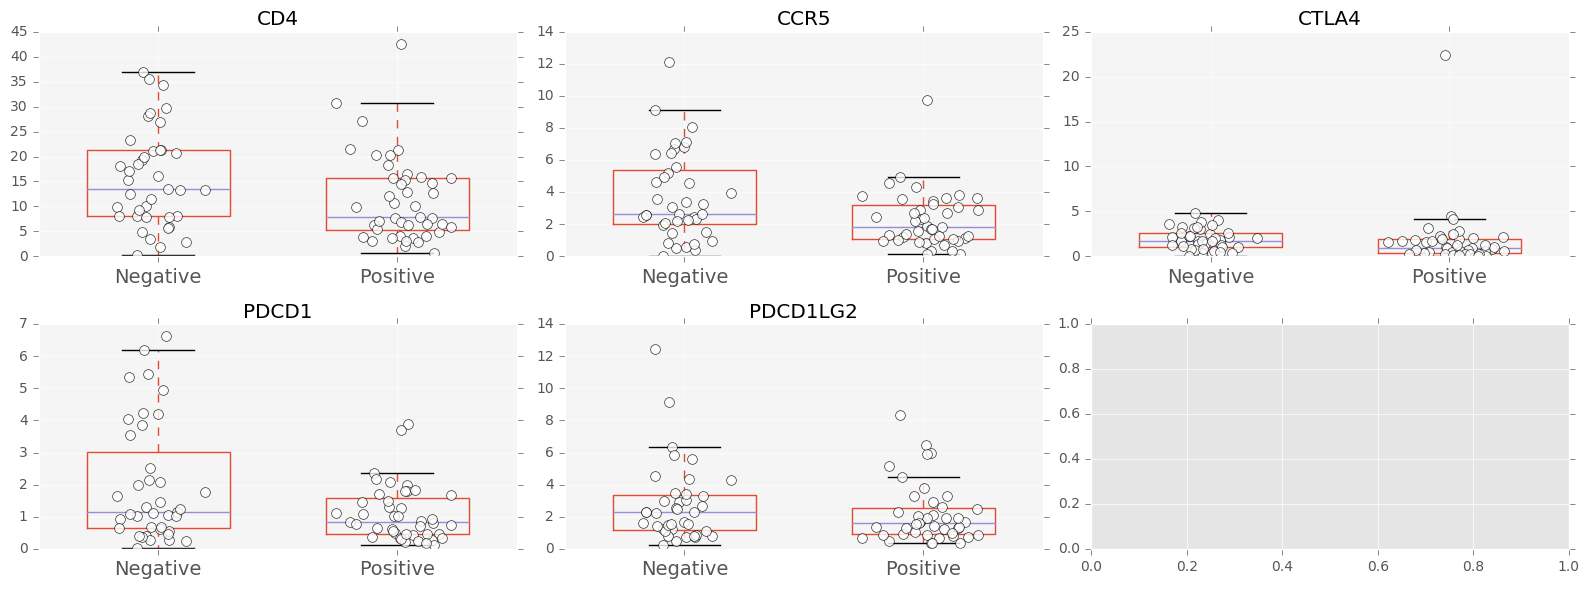

In [46]:
# boxplot hiv + vs -
fig, axes = plt.subplots(int(len(srt_genes)/3.0)+1, 3, figsize=(16, 6))
axes = axes.ravel()

for k, gene in enumerate(srt_genes):
        ax = axes[k]
        group_col = 'HIV_status'
        value_col = gene
        df_jnt.boxplot(ax=ax, column=value_col, by=group_col, showfliers=False, widths=(0.6,0.6), figsize=(5,5))
#         plt.title('') # this removes the column as subtitle of the plot
        fig = ax.get_figure()
        # fig.suptitle('')

        np.random.seed(0)
        # overlay actuall data points
        categories = df_jnt[group_col].unique().tolist()
        for category in categories:
            y = df_jnt[value_col][df_jnt[group_col]==category]
        #     i = categories.index(category) + 1
            if category == 'Negative':
                i = 1
            elif category == 'Positive':
                i = 2
            # add jitter and specify maker facecolor and edgecolor
            x = np.random.normal(i, 0.1, size=len(y))
            ax.plot(x, y, 'o', markerfacecolor='white',markeredgecolor='black', markersize=7, alpha=0.8)

        # ax.set_ylim(0,0.1)
        ax.set_axis_bgcolor('whitesmoke') #specify plot backgroup color
        ax.tick_params(axis='x', labelsize=14) #specify x tick label size
        # ax.set_ylim(0,200000)
        ax.set_xlabel(' ', fontsize=14)
        ax.set_ylabel(' ', fontsize=14)
    #     ax.suptitle(' ', fontsize=14)  # get rid of the automatically generated title
        plt.tight_layout()
        fig_name = '.'.join([gene, 'png'])
        plt.savefig(fig_name, dpi=200)

 
plt.suptitle(' ', fontsize=14)       
plt.savefig('/projects/trans_scratch/validations/workspace/szong/Cervical/immune_expression/test.png', dpi=200)


# use tsne to visualize the expression high dimensional data

In [53]:
df_jnt = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/immune_expression/expression_matrix.dedup.merged.status.txt')
# df_jnt.shape
# df_jnt.head(2)
ALL_GENES = [_ for _ in df_jnt.columns.values.tolist() if _ not in ['putative_Histology', 'HIV_status', 'patient']]
# len(ALL_GENES)
# df_jnt.head(2)
# df_jnt.columns.value_counts().unique()
# len(ALL_GENES)

In [54]:
# loistic regression to find most distinguishing genes
candidate_genes = list(sorted(ALL_GENES))
df_X = df_jnt[candidate_genes].copy()
df_y = df_jnt['HIV_status'].apply(lambda v: 0 if v == 'Negative' else 1)
# df_X.shape
# df_y.shape
clf = LogisticRegression(C=1, penalty='l2')
clf.fit(df_X, df_y)
# clf.coef_[0].shape

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
df_coef = pd.DataFrame(zip(candidate_genes, clf.coef_[0]), columns=['gene', 'coef'])
df_coef['abs_coef'] = df_coef.coef.abs()
df_coef.sort_values('abs_coef', ascending=False, inplace=True)
# df_coef
sel_genes = df_coef.head(10).gene.values
# len(sel_genes)


In [56]:
df_expr = df_jnt.copy()
# scale data
%time df_expr_scaled = StandardScaler().fit_transform(df_expr[sel_genes].values)
# df_expr[sel_genes]

CPU times: user 21 ms, sys: 0 ns, total: 21 ms
Wall time: 5.12 ms


In [57]:
# Create a Randomized PCA model that takes two components
randomized_tsne = TSNE(n_components=2, learning_rate=5, perplexity=30, verbose=True)
# randomized_tsne = RandomizedPCA(n_components=2)
# randomized_tsne = PCA(n_components=2)
# Fit and transform the data to the model
# reduced_data_rtsne = randomized_tsne.fit_transform(expression)
# reduced_data_rtsne = randomized_tsne.fit_transform(reduced)
reduced_data_rtsne = randomized_tsne.fit_transform(df_expr_scaled)
# reduced_data_rtsne.shape
# print(reduced_data_rtsne)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 81 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 82 / 82
[t-SNE] Mean sigma: 1.501611
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.444126
[t-SNE] Error after 300 iterations: 0.444126


In [58]:
df_embed = pd.DataFrame(reduced_data_rtsne, columns=['x', 'y'])
df_embed['HIV_status'] = df_expr.HIV_status.values
df_embed['color'] = df_embed['HIV_status'].apply(lambda v: 0 if v == 'Negative' else 1)

In [59]:
df_embed.head()

,x,y,HIV_status,color
0,-1.934829,1.053396,Positive,1
1,1.712143,-0.488929,Negative,0
2,0.662742,1.659029,Positive,1
3,0.958385,0.083743,Negative,0
4,1.423805,-0.460154,Negative,0


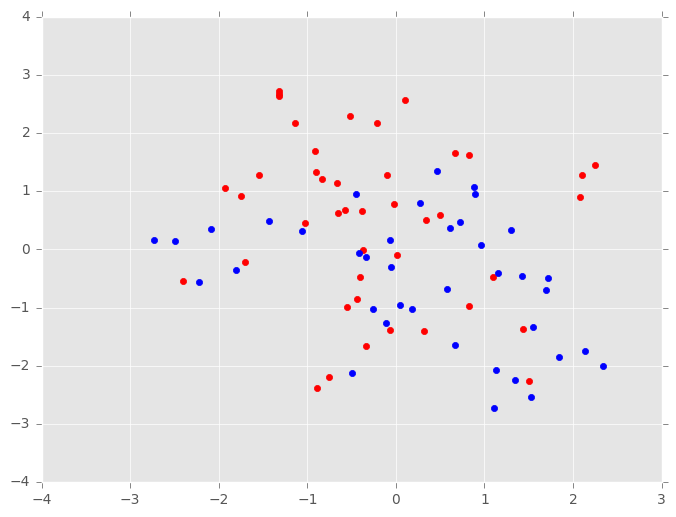

In [63]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
# ax.scatter(*reduced_data_rtsne.T)
# df_embed.plot.scatter(x='x', y='y', ax=ax, c=df_embed.color.values)

for i in ['Positive', 'Negative']:
    col = 'blue' if i == 'Negative' else 'red'
    _df = df_embed.query('HIV_status == "{0}"'.format(i))
    ax.scatter(_df['x'].values, _df['y'].values, color=col)

In [393]:
df_jnt['CD4']

0      4.9655
1     13.2054
2     16.4414
3     10.1120
4     28.0539
5     15.3517
6      8.1018
7     18.1117
8     15.8280
9     21.1948
10     8.1593
11    13.5350
12     7.9053
13    23.2196
14    16.0456
15     5.8347
16    15.7068
17     6.5621
18     6.2292
19     7.8638
20     1.9428
21    29.7691
22    36.9461
23    10.6766
24     7.6632
25     3.4928
26     4.8944
27    12.8546
28    28.6762
29     6.8959
       ...   
52     2.8734
53    17.1700
54     5.6284
55    19.3586
56    18.4659
57    19.8147
58    11.4371
59    21.2499
60    12.5690
61     7.0495
62     5.8118
63    27.1268
64    21.3168
65    15.7287
66     0.6573
67    14.6911
68    14.5548
69    13.2676
70     3.0424
71    20.2035
72    21.5861
73    12.0835
74    42.5732
75     6.5555
76     4.1686
77    18.3819
78    20.3257
79     3.0635
80     3.9297
81     9.7960
Name: CD4, dtype: float64

# summarize KMT2 and KDM5 mutations

In [173]:
columns = ['gene', 'chromosome', 'position', 'ref_base', 'alt_base', 'patient_ID', 'snpeff_details']
genes = ['MLL', 'MLL2', 'MLL3', 'MLL4', 'MLL5', 'SETD1A', 'SETD1B', 'KDM5A', 'KDM5B']

In [174]:
df_snvs = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/101_patients/HIGH_MODERATE_SNV_summary_with_normal_with_AF_filtered.tsv', skiprows=312, sep='\t')
df_snvs.head(2)
# filer rows with a list
snv_tmp = df_snvs[df_snvs['gene'].isin(genes)]
snv_tmp = snv_tmp[columns]
snv_tmp.head(2)

,gene,chromosome,position,ref_base,alt_base,patient_ID,snpeff_details
4061,MLL2,12,49445116,C,G,HTMCP-03-06-02209_Malignant,NON_SYNONYMOUS_CODING(MODERATE|MISSENSE|Gag/Ca...
4062,MLL2,12,49420880,C,T,HTMCP-03-06-02214_Malignant,NON_SYNONYMOUS_CODING(MODERATE|MISSENSE|Gaa/Aa...


In [146]:
snv_tmp.shape

(95, 7)

In [147]:
df_indels = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/101_patients/HIGH_MODERATE_INDEL_summary_with_normal_strelka_only.tsv', sep='\t')
indel_tmp = df_indels[df_indels['gene'].isin(genes)]
indel_tmp = indel_tmp[columns]
indel_tmp.head(2)

,gene,chromosome,position,ref_base,alt_base,patient_ID,snpeff_details
82,MLL3,7,151879476,CTG,C,HTMCP-03-06-02097_Malignant,FRAME_SHIFT(HIGH||-|-1823|4911|MLL3|protein_co...
83,MLL3,7,151927034,AACACTGACC,A,HTMCP-03-06-02001_Malignant,CODON_DELETION(MODERATE||ggtcagtgt/-|GQC981-|4...


In [148]:
indel_tmp.shape

(7, 7)

In [149]:
# concat 2 dataframes
df_cnct = pd.concat([snv_tmp, indel_tmp])
df_cnct.shape

(102, 7)

In [150]:
df_cnct['mut_type'] = df_cnct.snpeff_details.apply(lambda x: x.split('(')[0])
df_cnct['patient'] = df_cnct.patient_ID.apply(lambda y: y.split('_')[0])
df_cnct.drop(['patient_ID', 'snpeff_details'], axis=1,inplace=True)
# df_cnct.set_index('patient', inplace=True)
df_cnct.head(2)

,gene,chromosome,position,ref_base,alt_base,mut_type,patient
4061,MLL2,12,49445116,C,G,NON_SYNONYMOUS_CODING,HTMCP-03-06-02209
4062,MLL2,12,49420880,C,T,NON_SYNONYMOUS_CODING,HTMCP-03-06-02214


In [172]:
# combine mutation for each patient into one row
def process_grp(grp):
    _df_or_sr = grp.apply(lambda col: ';'.join(col.unique().tolist()))
    _df = _df_or_sr.to_frame().T
    assert _df.shape[0] == 1
    return _df

In [171]:
# for name , grp in df_cnct.groupby(['patient', 'gene']):
#     print(name)
#     print(grp.apply(lambda col: ';'.join(col.apply(str).unique().tolist())))
df_cnct.apply(process_grp).reset_index(level=2, drop=True)


AttributeError: ("'str' object has no attribute 'unique'", u'occurred at index gene')

In [142]:
df_pivot = df_cnct.pivot(index='patient', columns='gene', values='mut_type')
df_pivot


KeyError: 'patient'

# Below get all genes related to immunodeficiency from a database using read_html

In [25]:
# look for immunodeficiency genes
import html5lib
import lxml
import bs4
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

df_id = pd.read_html('http://structure.bmc.lu.se/idbase/IDRefSeq/xml/idr/genes.html')

# read_html return a list of dataframe, in this case only one dataframe
df = df_id[0]
df = df.dropna()[df[0] != 'Disease'][[0,2,3]]
df.head()

# add column header to a dataframe
df.columns = ['disease', 'gene', 'band']

df.shape
df.to_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/immune_expression/immunodeficiency_genes.txt', sep='\t', index=False)

/home/szong/.local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


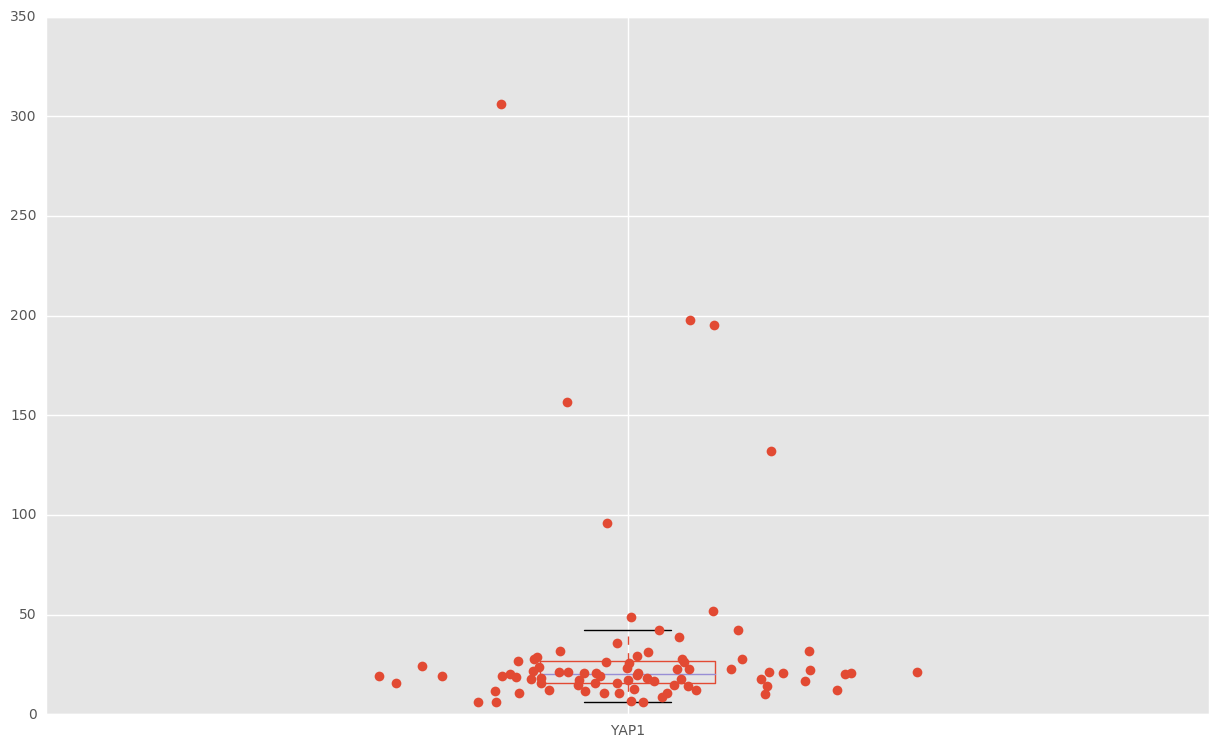

In [28]:
ax = df_tmp.boxplot()
y = df_tmp.YAP1
x = np.random.normal(1, 0.1, size=len(y))
plt.plot(x, y, 'o')
plt.savefig('/projects/trans_scratch/validations/workspace/szong/Cervical/immune_expression/YAP1.png')

In [177]:
gene_cols = df_expr.drop('lib', axis=1).columns.values

In [51]:
# np.save('/projects/trans_scratch/validations/workspace/szong/Cervical/immune_expression/expression_matrix.genes.npy', gene_cols)

In [178]:
df_stat = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/immune_expression/hiv_status.txt', sep='\t',header= None, names=['lib','hiv'])

In [179]:
df_stat.shape

(82, 2)

In [180]:
df_stat.head(2)

,lib,hiv
0,A37700,Positive
1,A37701,Negative


In [181]:
df_hist = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/82_patients/patient_histology_miRNA_prediction.csv', sep='\t')

In [182]:
df_hist.shape

(82, 23)

In [183]:
df_hist.head(2)

,mRNA_library,patient,putative_Histology,clinical_histolgy,Purity,num_mutated_genes,num_HPV_strains,PIK3CA,HLA-B,HLA-A,...,NFE2L2,ARID1A,CASP8,ERBB3,KRAS,PTEN,TGFBR2,MAPK1,MED1,HIV_status
0,A37700,HTMCP-03-06-02001,Squamous,NaN,60.00,247,1,Yes,No,No,...,No,No,No,No,No,No,No,No,No,Positive
1,A37701,HTMCP-03-06-02002,Squamous,NaN,71.25,180,1,Yes,No,Yes,...,Yes,No,No,No,No,No,No,No,No,Negative


In [184]:
df_hist.rename(columns={'mRNA_library': 'lib', 'HIV_status': 'hiv'}, inplace=True)

In [185]:
_mut_genes = ['PIK3CA', 'HLA-B', 'HLA-A', 'FBXW7', 'EP300', 'ERBB2', 'NFE2L2', 'ARID1A', 'CASP8', 'ERBB3', 'KRAS', 'PTEN', 'TGFBR2', 'MAPK1', 'MED1']
mut_genes = ['{0}_mut'.format(_) for _ in _mut_genes]

In [52]:
# np.save('/projects/trans_scratch/validations/workspace/szong/Cervical/immune_expression/expression_matrix.mut_genes.npy', np.array(mut_genes))

In [186]:
df_hist.rename(columns=dict(zip(_mut_genes, mut_genes)), inplace=True)

In [187]:
df_hist[mut_genes] = df_hist[mut_genes].replace({'Yes': 1, 'No': 0})

In [188]:
merged = pd.merge(df_expr, df_stat, on='lib')

In [189]:
merged = merged.merge(df_hist, on=['lib', 'hiv'])

In [190]:
merged.shape

(82, 42607)

In [44]:
# merged.to_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/immune_expression/expression_matrix.dedup.merged.txt', index=False)

add integration status


In [68]:
df_intg = pd.read_csv('/home/szong/projects/development/study/integration_status.txt')

In [70]:
df_intg.rename(columns={'library_RNA':'lib'}, inplace=True)

In [71]:
df_intg.head()

,lib,integration_status
0,A54479,integrated
1,A50346,integrated
2,A50345,integrated
3,A50344,unintegrated
4,A52345,integrated


In [191]:
df_expr.head(2)

,lib,SCYL3,C1orf112,FGR,CFH,STPG1,NIPAL3,AK2,KDM1A,TTC22,...,EIF4A1P2,MXRA5P1,CTBP2P1,ATP5JP1,PARP4P1,KALP,AC006157.2,RP11-886I11.1,RP11-886I11.3,RP11-886I11.2
0,A37700,3.6416,4.8082,0.7059,14.3879,1.6436,8.7098,29.0268,43.5168,18.7297,...,0.0,0.0799,0.0369,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
1,A37701,5.9656,3.9581,2.1283,22.7599,1.2715,6.1969,18.3112,21.3308,30.3388,...,0.0,0.0000,0.0000,0.0,0.0081,0.0,0.0,0.0,0.0,0.0


In [73]:
merged = df_expr.merge(df_intg)

In [74]:
merged.columns

Index([u'lib', u'SCYL3', u'C1orf112', u'FGR', u'CFH', u'STPG1', u'NIPAL3',
       u'AK2', u'KDM1A', u'TTC22',
       ...
       u'MXRA5P1', u'CTBP2P1', u'ATP5JP1', u'PARP4P1', u'KALP', u'AC006157.2',
       u'RP11-886I11.1', u'RP11-886I11.3', u'RP11-886I11.2',
       u'integration_status'],
      dtype='object', length=42586)

In [192]:
merged.shape

(82, 42607)

In [193]:
merged.head(2)

,lib,SCYL3,C1orf112,FGR,CFH,STPG1,NIPAL3,AK2,KDM1A,TTC22,...,ERBB2_mut,NFE2L2_mut,ARID1A_mut,CASP8_mut,ERBB3_mut,KRAS_mut,PTEN_mut,TGFBR2_mut,MAPK1_mut,MED1_mut
0,A37700,3.6416,4.8082,0.7059,14.3879,1.6436,8.7098,29.0268,43.5168,18.7297,...,0,0,0,0,0,0,0,0,0,0
1,A37701,5.9656,3.9581,2.1283,22.7599,1.2715,6.1969,18.3112,21.3308,30.3388,...,0,1,0,0,0,0,0,0,0,0


In [194]:
gene_cols.shape

(42584,)

In [ ]:
head

In [30]:
val_cols = gene_cols.tolist() + mut_genes

In [195]:
# extract expression columns for genes HPV integration disrupted
val_cols = gene_cols.tolist()
genes_disrupted = ['FHIT', 'STK11', 'NELFE', 'THADA', 'LYRM7', 'BC066991', 'RREB1', 'DLG2', 'PKD1L1', 'MIB1', 'UPK1B', 'CDC42SE1', 'PRIM2', 'MYC', 'CDH5', 'ERBB2', 'KRT32', 'RNF103-CHMP3', 'KRT26', 'LOC440434', 'CT64', 'KCNN3', 'AK127472', 'C12orf44', 'PTPN13', 'bpl', 'ACSL5', 'DQ515899', 'DQ515898', 'RNF103', 'RNA5-8S5', 'BC042052', 'RASSF6', 'CRTC3', 'CLTA', 'GPR137B', 'FNBP1L', 'MAML3', 'PSMG4', 'SKIV2L', 'RASEF', 'CEACAM6', 'TUBD1', 'B4GALT4', 'ARID2', 'LY86-AS1', 'MLLT11', 'COL4A5', 'GUCY2GP', 'RAB40B', 'ELOVL2', 'CYP21A1P', 'KIAA1958', 'SMIM19', 'BC037497', 'CD5', 'SERHL2', 'RMND5A', 'HINT1', 'TP63', 'HV975509', 'TBC1D3', 'BEAN1', 'C4B_2', 'C2', 'PRUNE', 'SUGT1P3', 'FGF12', 'RAD51B', 'IRS4', 'intergenic', 'IRS1', 'TPTE2P5', 'VARS', 'LOC646762', 'ELF1', 'FAM83B', 'MIEN1', 'LOC727677', 'KLF12', 'LRP1B', 'SCAF11', 'CYP21A2', 'NR4A1', 'TMEM242', 'AK096219', 'SLC20A2', 'MPPED2', 'CFB', 'CLPTM1L', 'ANKFN1', 'WBP4']
genes_final = [i for i in val_cols if i in genes_disrupted]

In [196]:
val_cols = genes_final

In [197]:
df_expr_scaled = merged[val_cols].copy()

In [198]:
df_expr_scaled.shape

(82, 74)

In [199]:
df_expr_scaled.columns.unique().shape

(74,)

In [200]:
print(df_expr_scaled.columns.tolist())

['GPR137B', 'FNBP1L', 'PRUNE', 'KCNN3', 'CDC42SE1', 'MLLT11', 'ACSL5', 'GUCY2GP', 'MPPED2', 'CD5', 'DLG2', 'NR4A1', 'C12orf44', 'SCAF11', 'ARID2', 'KLF12', 'WBP4', 'ELF1', 'TPTE2P5', 'SUGT1P3', 'RAD51B', 'CRTC3', 'BEAN1', 'CDH5', 'TUBD1', 'KRT32', 'RAB40B', 'ERBB2', 'MIEN1', 'ANKFN1', 'KRT26', 'TBC1D3', 'MIB1', 'CEACAM6', 'STK11', 'THADA', 'RMND5A', 'LRP1B', 'IRS1', 'RNF103', 'RNF103-CHMP3', 'SERHL2', 'TP63', 'FGF12', 'UPK1B', 'B4GALT4', 'FHIT', 'PTPN13', 'RASSF6', 'MAML3', 'CLPTM1L', 'HINT1', 'LYRM7', 'RREB1', 'PRIM2', 'C2', 'FAM83B', 'PSMG4', 'ELOVL2', 'CYP21A1P', 'SKIV2L', 'VARS', 'TMEM242', 'LY86-AS1', 'CYP21A2', 'CFB', 'PKD1L1', 'MYC', 'SLC20A2', 'CLTA', 'RASEF', 'KIAA1958', 'IRS4', 'COL4A5']


In [201]:
%time df_expr_scaled[val_cols] = StandardScaler().fit_transform(df_expr_scaled.values)

CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 1.79 ms


In [172]:
df_expr_scaled.head(2)

NameError: name 'df_expr_scaled' is not defined

In [30]:
# pca_2c = PCA(n_components=2)

# reduced = pca_2c.fit_transform(df_expr_scaled)

# reduced.shape

# reduced_df = pd.DataFrame(reduced, columns=['x', 'y'])
# reduced_df['hiv'] = merged.hiv.values

# ax = plt.axes()
# for i in ['Positive', 'Negative']:
#     col = 'blue' if i == 'Positive' else 'red'
#     _df = reduced_df.query('hiv == "{0}"'.format(i))
#     ax.scatter(_df['x'].values, _df['y'].values, color=col)

In [46]:
pca = PCA(n_components=50)

In [47]:
%time expression = pca.fit_transform(df_expr_scaled)

CPU times: user 2.81 s, sys: 68 ms, total: 2.88 s
Wall time: 834 ms


In [83]:
svd = TruncatedSVD(n_components=50)
%time reduced = svd.fit_transform(df_expr_scaled)

CPU times: user 3.25 s, sys: 89 ms, total: 3.34 s
Wall time: 924 ms


In [106]:
df_expr_scaled.shape

(82, 42584)

In [124]:
# Create a Randomized PCA model that takes two components
randomized_tsne = TSNE(n_components=2, learning_rate=10, perplexity=30, verbose=True)
# randomized_tsne = RandomizedPCA(n_components=2)
# randomized_tsne = PCA(n_components=2)
# Fit and transform the data to the model
# reduced_data_rtsne = randomized_tsne.fit_transform(expression)
# reduced_data_rtsne = randomized_tsne.fit_transform(reduced)
reduced_data_rtsne = randomized_tsne.fit_transform(df_expr_scaled)
# reduced_data_rtsne.shape
# print(reduced_data_rtsne)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 81 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 82 / 82
[t-SNE] Mean sigma: 3.983487
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.418799
[t-SNE] Error after 325 iterations: 0.418799


In [50]:
merged.putative_Histology.value_counts()

reduced_df = pd.DataFrame(reduced_data_rtsne, columns=['x', 'y'])
# reduced_df['hiv'] = merged.hiv.values
# reduced_df['putative_Histology'] = merged.putative_Histology.values
reduced_df['integration_status'] = merged.integration_status.values



ax = plt.axes()
# for i in ['Squamous', 'Adeno']:
for i in ['integrated', 'unintegrated']:
    col = 'blue' if i == 'integrated' else 'red'
    _df = reduced_df.query('integration_status == "{0}"'.format(i))
    ax.scatter(_df['x'].values, _df['y'].values, color=col)

Squamous    63
Adeno       19
Name: putative_Histology, dtype: int64

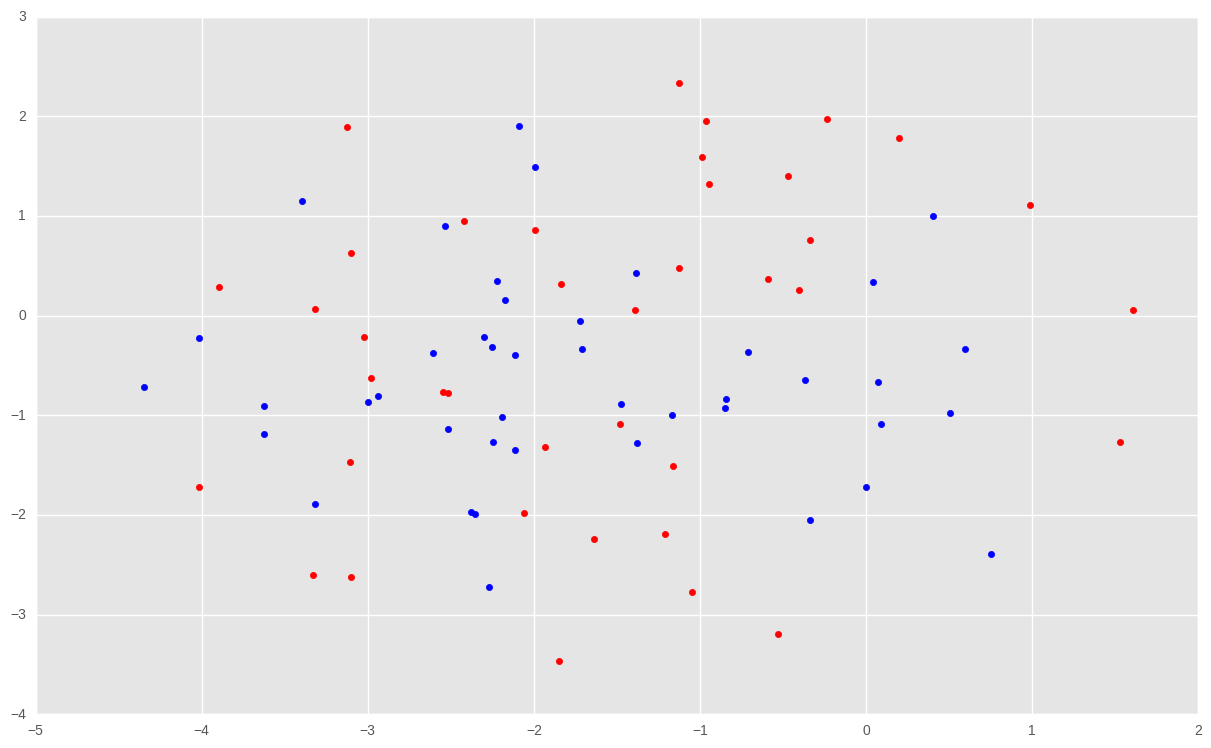

In [104]:
# ax = plt.axes()
# for i in ['Positive', 'Negative']:
#     col = 'blue' if i == 'Positive' else 'red'
#     _df = reduced_df.query('hiv == "{0}"'.format(i))
#     ax.scatter(_df['x'].values, _df['y'].values, color=col)

In [ ]:
statuses = merged['hiv']

for i in range(len(statuses)):
#     print(i)
    if statuses[i]=='Positive':
        x = reduced_data_rtsne[i][0]
        y = reduced_data_rtsne[i][1]
        plt.scatter(x,y,c='red')
    elif statuses[i]=='Negative':
        x = reduced_data_rtsne[i][0]
        y = reduced_data_rtsne[i][1]
        plt.scatter(x,y,c='blue')    
# plt.legend(digits.target_names, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('tsne1')
plt.ylabel('tnse2')
# plt.title("tsne Scatter Plot")
# plt.show()

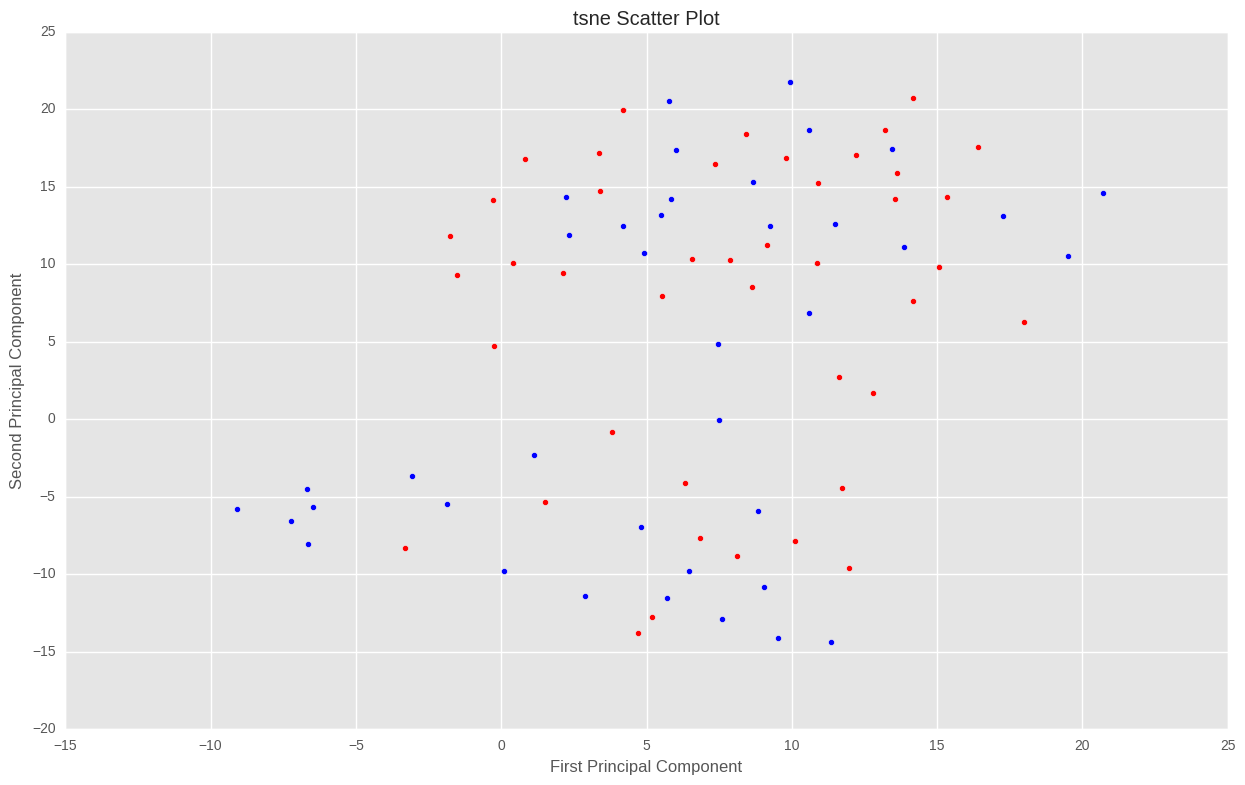

In [38]:
statuses = merged['hiv']

for i in range(len(statuses)):
#     print(i)
    if statuses[i]=='Positive':
        x = reduced_data_rtsne[i][0]
        y = reduced_data_rtsne[i][1]
        plt.scatter(x,y,c='red')
    elif statuses[i]=='Negative':
        x = reduced_data_rtsne[i][0]
        y = reduced_data_rtsne[i][1]
        plt.scatter(x,y,c='blue')    
# plt.legend(digits.target_names, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('tsne1')
plt.ylabel('tnse2')
# plt.title("tsne Scatter Plot")
# plt.show()


look at Keratin gene family

In [57]:
keratin_genes = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/immune_expression/keratin_gene_family.txt', sep='\t')

app_syms = keratin_genes['Approved Symbol'].tolist()

# flatten a list of lists to a flat list
lst = [i.split(', ') for i in keratin_genes['Previous Symbols'].dropna().tolist()]
pre_syms = [gene for sublist in lst for gene in sublist]
pre_syms

synonyms = [i.split(', ') for i in keratin_genes['Synonyms'].dropna().tolist()]
syn_syms = [gene for sublist in synonyms for gene in sublist]
syn_syms

com_syms = list(set(app_syms + pre_syms + syn_syms))
# com_syms

In [58]:
# add in some genes of cell cycle, antiviral, and epithilial differentiation
other_df = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/immune_expression/NIHMS452185-supplement-2.csv', sep='\t')
other_syms = other_df.Genes.tolist()
com_syms = list(set(com_syms + other_syms))
len(com_syms)

1434

In [59]:
expression = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/immune_expression/expression_matrix.dedup.merged.txt')

In [60]:
expression.head()

,lib,SCYL3,C1orf112,FGR,CFH,STPG1,NIPAL3,AK2,KDM1A,TTC22,...,ERBB2_mut,NFE2L2_mut,ARID1A_mut,CASP8_mut,ERBB3_mut,KRAS_mut,PTEN_mut,TGFBR2_mut,MAPK1_mut,MED1_mut
0,A37700,3.6416,4.8082,0.7059,14.3879,1.6436,8.7098,29.0268,43.5168,18.7297,...,0,0,0,0,0,0,0,0,0,0
1,A37701,5.9656,3.9581,2.1283,22.7599,1.2715,6.1969,18.3112,21.3308,30.3388,...,0,1,0,0,0,0,0,0,0,0
2,A37702,4.1159,3.6884,2.5235,31.4999,1.5497,5.8850,18.4245,30.6941,6.5238,...,0,0,0,0,0,0,0,0,0,0
3,A37704,5.5611,7.3219,1.4132,38.0311,1.7007,5.3582,16.8159,26.8179,5.2079,...,0,0,0,0,0,0,0,0,0,0
4,A37705,4.7210,3.1647,4.8690,10.7216,2.0805,4.6086,15.4853,63.0492,0.7716,...,0,0,1,1,1,1,1,1,0,0


In [61]:
inte_df = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/integration/82_patients/hist_hpv_hiv_status.csv')
inte_df.head()
expr_merge = pd.merge(expression, inte_df, left_on='lib', right_on='library_RNA')

In [62]:
expr_merge.head()
expression = expr_merge

In [78]:
expression_scaled.head(2)

,SCYL3,C1orf112,AK2,RUNX3,GLRX2,DEPDC1,ZZZ3,TPR,PTGER3,SOAT1,...,AR,NR0B1,MED14,EFHC2,APOO,BCAP31,ERCC6L,CXorf27,TRAPPC2,NUP62CL
0,-0.317889,0.643999,1.337348,0.583367,-0.340044,1.854898,1.429226,-0.257169,-0.395892,-0.704066,...,-0.480706,-0.120796,-0.268341,-0.635662,-0.810549,-1.017284,0.940234,-0.251867,-0.564226,0.502268
1,1.251757,0.176119,-0.372593,0.274366,1.696321,1.637549,0.399720,0.100149,-0.589477,0.026325,...,-0.510569,-0.123218,-0.537394,-0.574296,0.401364,1.548596,-0.394035,-0.251867,2.089378,1.761608


In [79]:
expression_scaled[keratin_genes].head(2)

,SCYL3,C1orf112,AK2,RUNX3,GLRX2,DEPDC1,ZZZ3,TPR,PTGER3,SOAT1,...,AR,NR0B1,MED14,EFHC2,APOO,BCAP31,ERCC6L,CXorf27,TRAPPC2,NUP62CL
0,-0.317889,0.643999,1.337348,0.583367,-0.340044,1.854898,1.429226,-0.257169,-0.395892,-0.704066,...,-0.480706,-0.120796,-0.268341,-0.635662,-0.810549,-1.017284,0.940234,-0.251867,-0.564226,0.502268
1,1.251757,0.176119,-0.372593,0.274366,1.696321,1.637549,0.399720,0.100149,-0.589477,0.026325,...,-0.510569,-0.123218,-0.537394,-0.574296,0.401364,1.548596,-0.394035,-0.251867,2.089378,1.761608


In [63]:
keratin_genes = [i for i in expression.columns if i in com_syms]


expression_scaled = expression[keratin_genes]

%time expression_scaled[keratin_genes] = StandardScaler().fit_transform(expression_scaled.values)

# Create a Randomized PCA model that takes two components
randomized_tsne = TSNE(n_components=2, learning_rate=5, perplexity=30, verbose=True)
# randomized_tsne = RandomizedPCA(n_components=2)
# randomized_tsne = PCA(n_components=2)
# Fit and transform the data to the model
# reduced_data_rtsne = randomized_tsne.fit_transform(expression)
# reduced_data_rtsne = randomized_tsne.fit_transform(reduced)
reduced_data_rtsne = randomized_tsne.fit_transform(expression_scaled)
# reduced_data_rtsne.shape
# print(reduced_data_rtsne)

In [67]:
[i for i in expression.columns if 'isto' in i]
# expression.hiv


['putative_Histology_x', 'clinical_histolgy', 'putative_Histology_y']

In [73]:
reduced_df.head(2)

,x,y,putative_Histology,hiv,RNA_integration_status
0,0.550009,-0.375119,Squamous,Positive,integrated
1,1.206331,-0.465003,Squamous,Negative,integrated


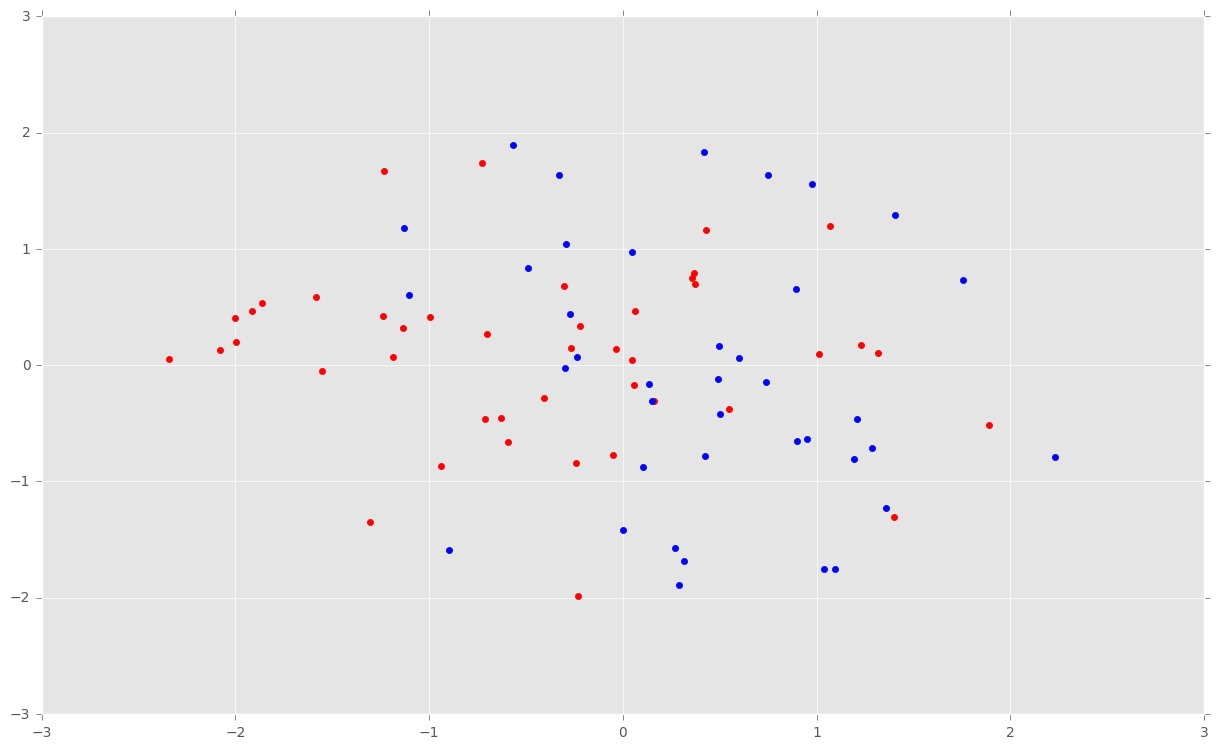

In [75]:

reduced_df = pd.DataFrame(reduced_data_rtsne, columns=['x', 'y'])
reduced_df['putative_Histology'] = expression.putative_Histology_x.values
reduced_df['hiv'] = expression.hiv.values
reduced_df['RNA_integration_status'] = expression.RNA_integration_status.values
fig = plt.figure(figsize=(15,9))

ax = fig.add_subplot(111)

# for i in ['Squamous', 'Adeno']:
#     col = 'blue' if i == 'Squamous' else 'red'
#     _df = reduced_df.query('putative_Histology == "{0}"'.format(i))
#     ax.scatter(_df['x'].values, _df['y'].values, color=col)
# plt.savefig('keratin_family_gene_expression.png', dpi=200)
for i in ['Positive', 'Negative']:
    col = 'blue' if i == 'Negative' else 'red'
    _df = reduced_df.query('hiv == "{0}"'.format(i))
    ax.scatter(_df['x'].values, _df['y'].values, color=col)

# for i in ['integrated', 'unintegrated']:
#     col = 'blue' if i == 'Squamous' else 'red'
#     _df = reduced_df.query('putative_Histology == "{0}"'.format(i))
#     ax.scatter(_df['x'].values, _df['y'].values, color=col)
# plt.savefig('keratin_family_gene_expression.png', dpi=200)

In [394]:
print '{0}'.format(', '.join([f for f in expression_scaled.columns.tolist()]))

SCYL3, C1orf112, AK2, RUNX3, GLRX2, DEPDC1, ZZZ3, TPR, PTGER3, SOAT1, LAMC2, SPEN, ASPM, LRRC40, NUCKS1, UBE2T, GNB1, DUSP12, HSPB11, TTC39A, RAD54L, FMO2, CACYBP, ANGPTL1, ICMT, HDAC1, S100PBP, DLEU2L, NCF2, TSNAX, LGALS8, SSX2IP, CDC20, SERPINC1, NEK2, RPS6KA1, NSL1, CENPF, RPA2, HEATR1, CD244, CDKN2C, STIL, HNRNPR, PSMB2, IFI6, PPT1, CHD1L, RHBG, NASP, GSTM5, PSRC1, TRIM45, CRB1, CDCA8, GNL2, ZCCHC11, AGT, PCNXL2, DHX9, KIAA1614, BCAR3, IFI44L, IFI44, EFHD2, C1orf216, ITGB3BP, KIF2C, PTPRF, GJA5, TIPRL, PFDN2, ISG20L2, XPR1, ZNF687, TARS2, SETDB1, RFX5, ANP32E, ANXA9, DTL, INTS7, TAF1A, CRNN, UBAP2L, EFNA3, FLG, GALNT2, WDR78, HNRNPU, AHCTF1, AK5, SLC16A1, C1orf27, NECAP2, LRP8, CD1C, TAGLN2, CDA, APOA2, PSMD4, PSMB4, ADAR, UBE2Q1, SLC25A44, MAGOH, NOL9, RBBP4, RBM15, SPRR3, LENEP, ATP1A1, CCT3, NUAK2, IFI16, AIM2, EFNA1, SPRR1A, OTUD3, KCND3, LRRC8D, CKS1B, SELP, EXO1, AKIRIN1, ANGEL2, MARCKSL1, AIM1L, FCER1A, PTP4A2, SMYD3, ROR1, MUC1, TOR3A, ISG15, GPR89B, AGRN, CNR2, MMP23B, SEM

In [350]:
expression[['lib', 'putative_Histology', 'clinical_histolgy']][expression['putative_Histology']=='Adeno']

,lib,putative_Histology,clinical_histolgy
4,A37705,Adeno,NaN
9,A37711,Adeno,NaN
15,A37719,Adeno,NaN
18,A37722,Adeno,NaN
25,A37730,Adeno,NaN
26,A37731,Adeno,NaN
28,A37733,Adeno,NaN
32,A37737,Adeno,NaN
33,A37738,Adeno,NaN
36,A50338,Adeno,NaN


In [348]:
reduced_df

,x,y,putative_Histology
0,-0.735339,-0.240601,Squamous
1,-1.285389,0.924262,Squamous
2,0.382438,-0.497136,Squamous
3,-0.832637,1.171645,Squamous
4,0.945405,0.102200,Adeno
5,0.615101,1.018947,Squamous
6,-1.212246,-0.873216,Squamous
7,2.316352,-1.994298,Squamous
8,-1.186949,-1.401019,Squamous
9,1.105395,0.182886,Adeno
